# House Price Prediction (Linear Regression & Decision Tree Regression)

## Context
Data source, goal, etc:

- This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.
<br><br>
- For the sake of simplicity, it may be better to perform the analysis as if it were the year that these houses were sold. This will remove the possible need to adjust the age of the houses for the current year (2024) and adjust prices for inflation. The data is the selling price of the homes in 2014/15 and this is more reflective of that current market price opposed to the homes underlying value. There are many other market factors that can effect this and will also need to be taken into consideration should a dataset this old be used for present day predictions/inferences. I think simplicity should prevail here. 

**Dataset:**<br>
<a href="https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion?sort=undefined"> House Sales in King County, USA (Kaggle)</a> <br>
*note: In this project I am using a smaller version of this dataset with fewer features and instances.*
<br><br>

**Column Definitions:**<br>
id - Unique ID for each home sold <br>
date - Date of the home sale <br>
price - Price of each home sold <br>
bedrooms - Number of bedrooms <br>
bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower <br>
sqft_living - Square footage of the apartments interior living space <br>
sqft_lot - Square footage of the land space <br>
floors - Number of floors (0.5 = split-level or bi-level floors)<br>
waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not <br>
view - An index from 0 to 4 of how good the view of the property was <br>
condition - An index from 1 to 5 on the condition of the apartment <br>
grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. <br>
sqft_above - The square footage of the interior housing space that is above ground level <br>
sqft_basement - The square footage of the interior housing space that is below ground level <br>
yr_built - The year the house was initially built <br>
yr_renovated - The year of the house’s last renovation <br>
zipcode - What zipcode area the house is in <br>
lat - Lattitude <br>
long - Longitude <br>
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors <br>
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors <br>

verified from 2 sources: <br>
https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices <br>
https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html

## To do List:
- Go back and preprocess the data properly, dummy variables before scaling and consider whether or not categorical values need to be scaled because they probably don't/shouldn't be scaled.
- Output of the estimated coefficients?
- Some kind of plot of the model's performance? How might I do this with multiple input variables 
- Longitude and latitude could be used to engineer a new nominal categorical feature that states the area code or something similar that the house exists in, otherwise I'm not sure how it may be useful. Latitude has a much higher linear correlation with price so it's possible that the categorical variable could be something along the lines of "east", "central" and "west".
- sqft_ living, lot, above, basement, living15 and lot15 all seem to be describing something similar and may require some form of feature engineering
- sqft_living15 and sqft_lot15 could be used as comparitive values that capture how large a house is relative to it's neighbourhood. Create new feature that is a percentage of the average living and lot space. I.e., "this house is twice as large as the homes in its area". This may be useful information. 
- Consider scaling house prices too and/or log transforming due to heavy positived skewdness.
- I have z-score standardised long and lat features just like all of the other continuous variables but I am not sure that this is a sensible thing to do.
- I have not really verified the quality of the continuous variables before scaling them. I may need to go back and do this.
- Consider using multiple evaluation metrics: R^2 Adj. R^2, RMSE, MSE, MAE
<br><br><br>
- **Remember to include a HTML version of the notebook as well as the .ipynb file when ready to submit.**<br>
$ !jupyter nbconvert --to html your_notebook.ipynb


## Set up

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set()

In [2]:
data = pd.read_csv("../data/kc_house_data.csv")
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [3]:
# Investigating the data's structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   grade          21613 non-null  int64  
 7   sqft_above     21613 non-null  int64  
 8   sqft_basement  21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  yr_renovated   21613 non-null  int64  
 11  lat            21613 non-null  float64
 12  long           21613 non-null  float64
 13  sqft_living15  21613 non-null  int64  
 14  sqft_lot15     21613 non-null  int64  
 15  condition      21613 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 2.6 MB


In [4]:
# Investigating simple summary statistics
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652,3.409430
std,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631,0.650743
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000,3.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000,4.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,5.000000


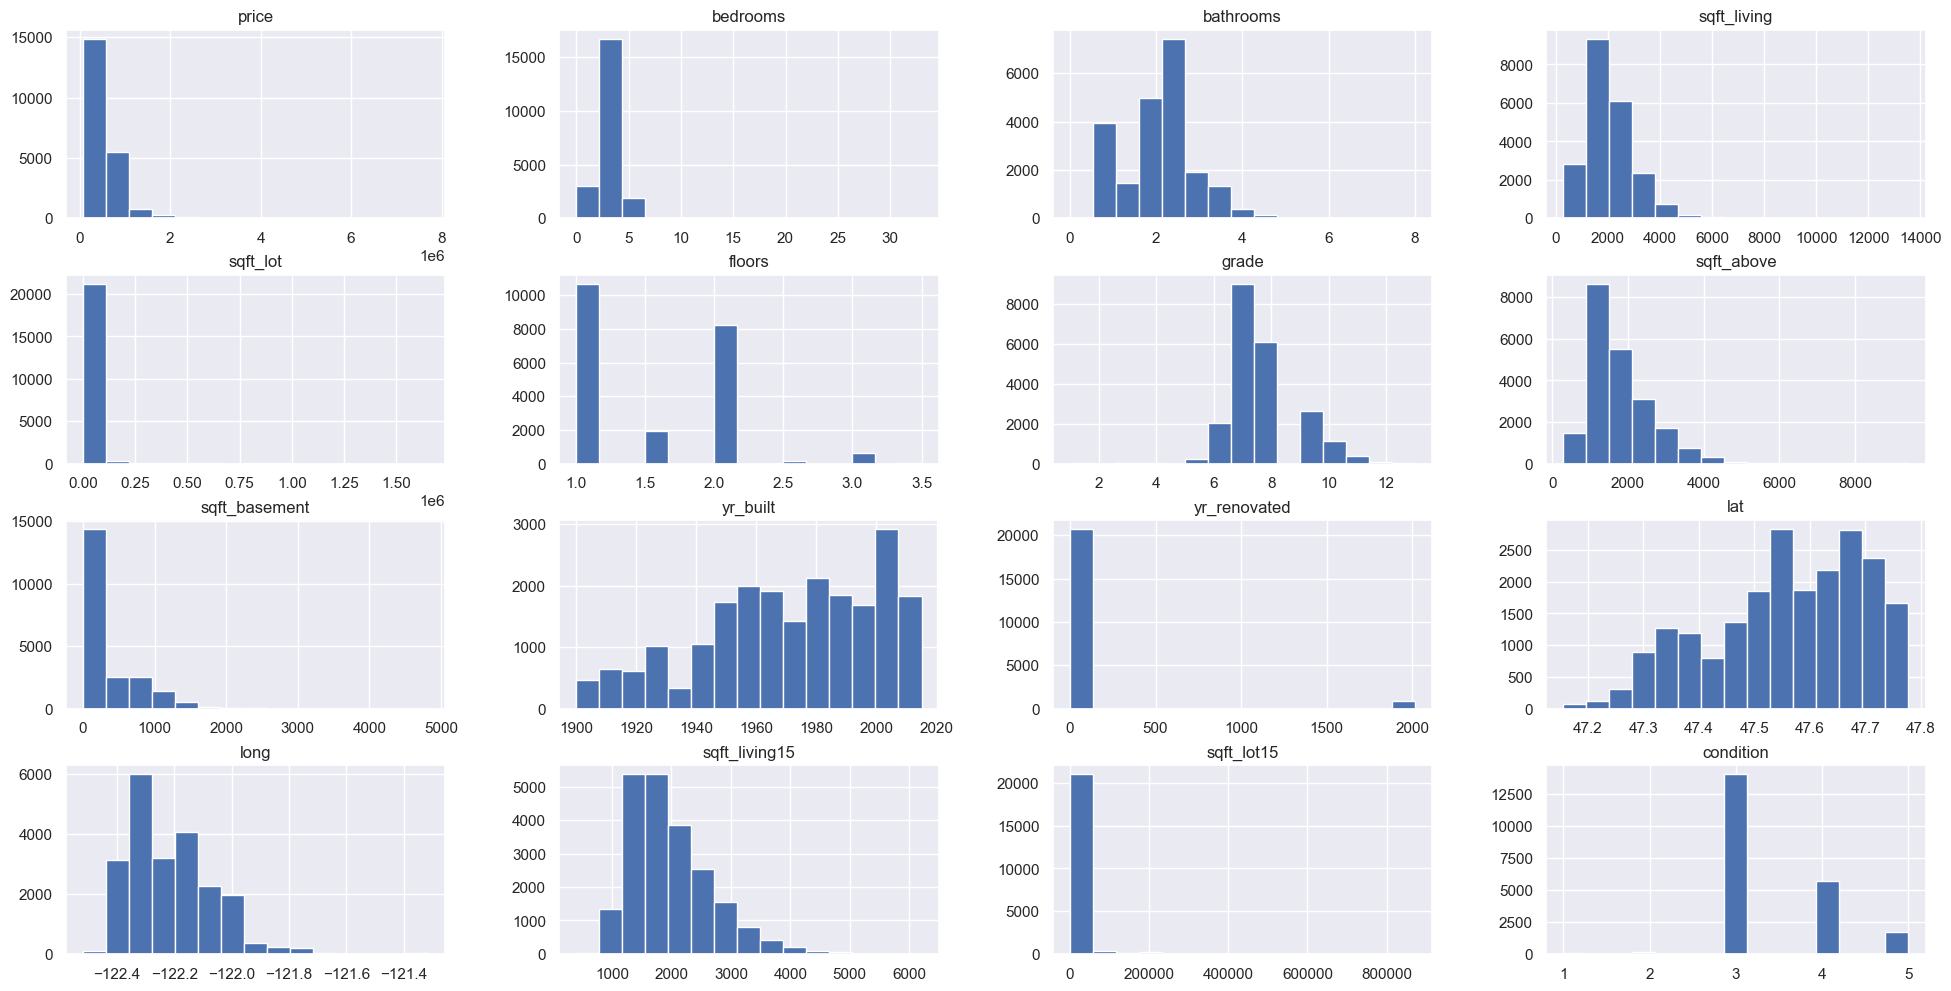

In [5]:
# Quick look at the distribution of all features
data.hist(bins=15, figsize=(24,12));

In [6]:
# Creating the train-test split before any further exploration to avoid any "data snooping" bias
train_set, test_set = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
price_df = train_set.copy()

## Defined Functions
I will keep any functions I have defined under this subsection for easier debugging and improved notebook organisation

In [7]:
def reorder_col(data, col_name, after):
    '''
    Function will take in a dataframe and move a column specified by name to another position in the dataframe after any other column also specified by name.
    I will use this after creating new features and would like to quickly place them elsewhere in the existing dataframe - usually just after the features they have been engineered from.
    
    Return: The input dataframe with new column order
    '''
    
    col_values = data.pop(col_name) #remove the column
    position = data.columns.get_loc(after) #Index location of the column I want to insert the new column after
    data.insert(position+1, col_name, col_values) #Insert after the specified column
    
    return data

In [8]:
def renovated_within(data, yrs_within):
    '''
    this function will take 2 arguements: 
        The first is the dataframe to be operated on.
        The second will specify a cut-off point for the number of years that have passed since the house was last renovated (relative to 2015).
    
    If the house has been renovated within the specified number of years the result will be a 1, otherwise it will be a 0.
    All houses that have not been renovated at all will result in a 0.
    
    The resulting output will be a new dataframe with an added binary feature specifying whether the house had been renovated within the specified number of years.
    '''
    
    renovated_list = []
    for year in data['yr_renovated']:
        if year != 0: #If the house has been renovated then calculate how long ago
            yrs_since_renov = 2015-year
            
            if yrs_since_renov <= yrs_within: #If renovations occured within specified time frame then 1, representing yes
                renovated_list.append(1)
            else:
                renovated_list.append(0)
        
        else: #If the house has not been renovated at all then 0, representing no
            renovated_list.append(0)
    
    # Add new column to the dataframe
    col_name = f"renovated_within_{yrs_within}_yrs"
    data[col_name] = renovated_list
    
    return data

In [67]:
# Graphical investigation of linear relationships (if any) between target variable and other independent variable

def four_scatterplots(data, col_range):
    '''
    Plot a selection of 4 features in the dataset against the price target variable, side by side.
    Takes in a dataframe and a list of 2 intergers specifying the range of the four features to be plotted.
    Outputs a subplot of 1x4 scatterplots.
    '''
    
    fig, axs = plt.subplots(1, 4, figsize=(35,6))
    
    for i, col in enumerate(data.columns[col_range[0]:col_range[1]]):
        sns.scatterplot(data=data, x=col, y='price', ax=axs[i])
        
    plt.show()
    


## Exploratory Analysis

### General Exploration
For now, I will lead with curiosity and aim to develop a better sense of the data before looking for anything specific.

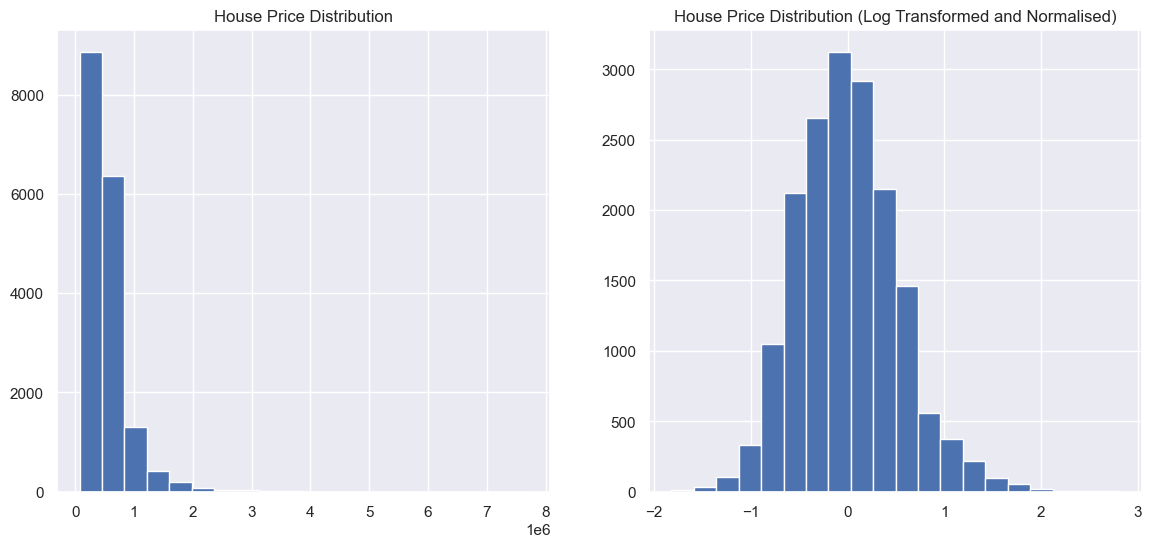

In [14]:
# Due to how positively skewed house prices are, a log transformation of the target variable may lead to improved model performance
# Below I am simply investigating the log transformed (and 0 centred) distribution of the house prices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))


#tst_million = price_df['price'] /1_000_000
tst_log = np.log(price_df['price'])
tst_mean_norm = tst_log - np.mean(tst_log)

# tst_mean_norm.hist(bins=20)

ax1.hist(price_df['price'], bins=20)
ax2.hist(tst_mean_norm, bins=20)

ax1.title.set_text("House Price Distribution")
ax2.title.set_text("House Price Distribution (Log Transformed and Normalised)")
plt.show();

In [1]:
# Quick look at potentially interesting linear relationships between all variables
plt.figure(figsize=(8,8))
sns.heatmap(price_df.corr())

plt.show();

NameError: name 'plt' is not defined

''

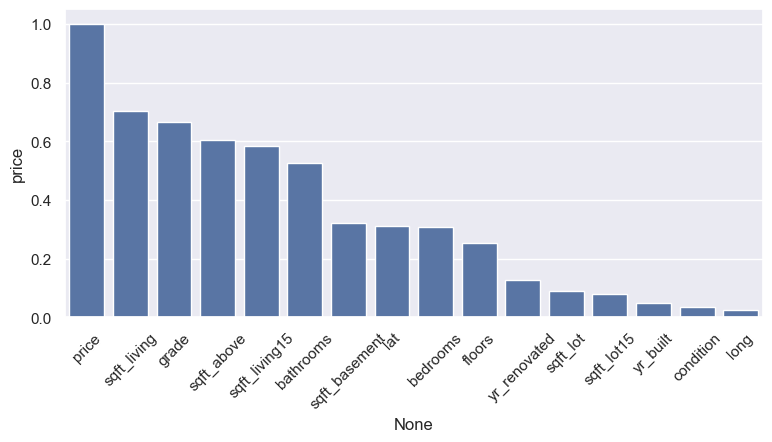

In [11]:
# Ordered bar chart of Pearson correlation coefs of each feature and the house price 
corr_matrix = price_df.corr()[['price']].sort_values('price', ascending=False)

plt.subplots(figsize=(9,4))
plt.xticks(rotation=45)

sns.barplot(x=corr_matrix.index, y=corr_matrix['price'])
;

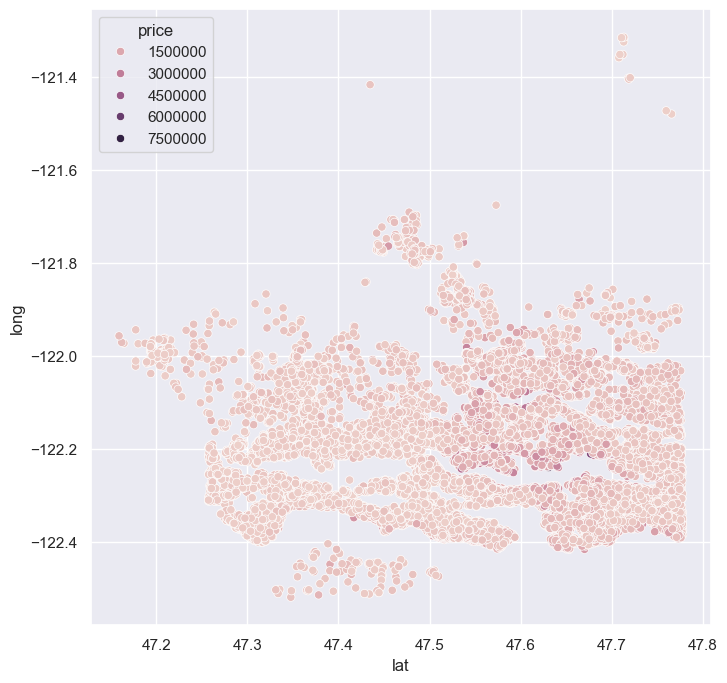

In [13]:
# Heat map of house prices relative to their location
# The highest priced houses that were sold seem to be concentrated around a particular area, however this may not be a strong indication 
# of any useful pattern that the model's can generalise to improve predictive power.

plt.figure(figsize=(8,8))
sns.scatterplot(data=price_df, x='lat', y='long', hue='price');

### Assessing Linear Regression Assumptions
- If I am to model the data using linear regression it will be important to check whether the key assumptions of linear regression have been met.
<br>
Assumptions:
1. Linear relationship
    - Correlation matrix
    - Scatter plots
    - Pairplots
    - Partial regression plots
    - Residual plots
    - "Verify that the relationship between each independent variable and the dependent variable is linear." Is this true/needed?
<br><br>
2. Normal distribution of errors
    - ...
    -
    -
<br><br>
3. Homoscedasticity
    - "Ensure that the variance of residuals is constant across values of the independent variables. Use residual vs. fitted value plots to assess."
    -
    -
<br><br>
4. Multicolinearity (as the use case is soley for predictive purposes and not inferential analysis, this may not matter; the parameter estimations are less important than the model's predictive power)
    - Calculate variance inflation factor (VIF)
    - Correlation matrix among independent variables
    -
<br><br>
    
5. **Not sure what category these will fall under**
    - "Normality of Residuals: Use histograms or Q-Q plots of residuals to check for normality."
    - "Independence of Errors: Verify that residuals are independent (e.g., using Durbin-Watson test for time-series data)."

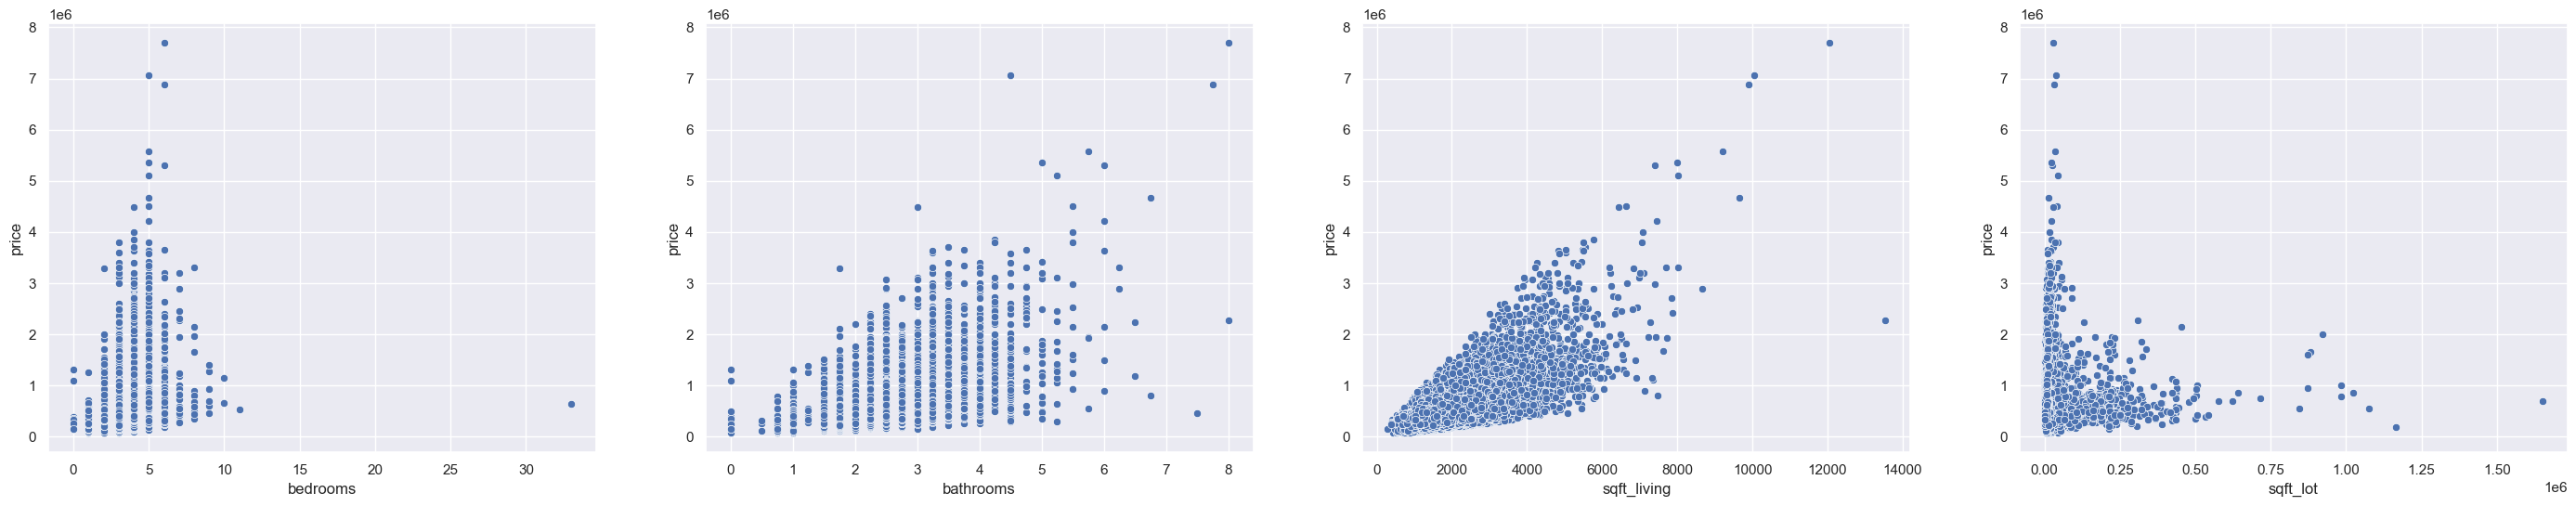

In [69]:
# Scatter plots of bedrooms, bathrooms, sqft_living and sqft_lot against price
four_scatterplots(data=data, col_range=[1, 5])

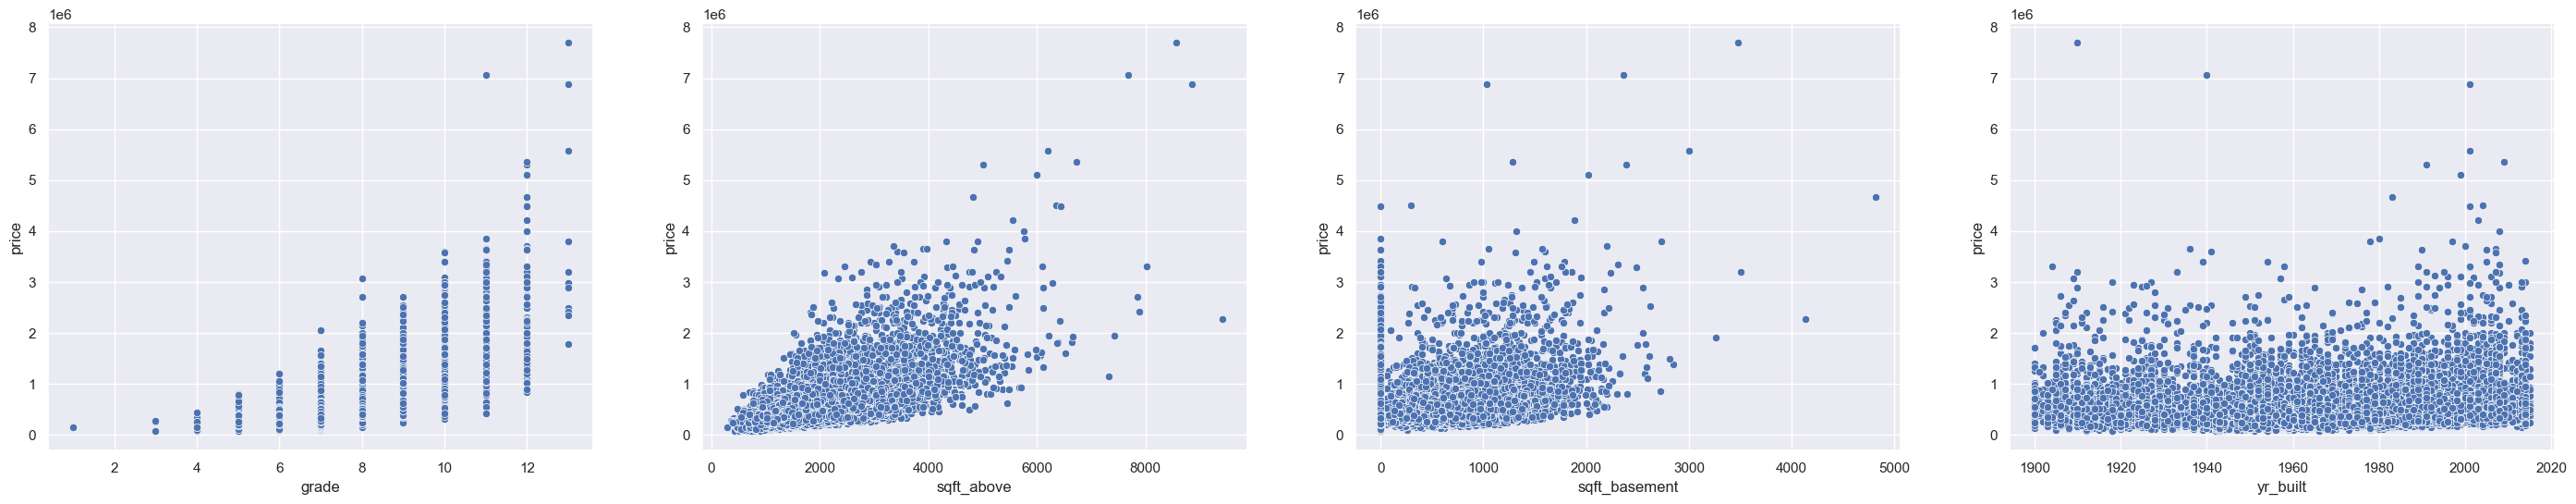

In [70]:
# Scatter plots of floors, grade, sqft_above and sqft_basement against price
four_scatterplots(data=data, col_range=[5, 9])

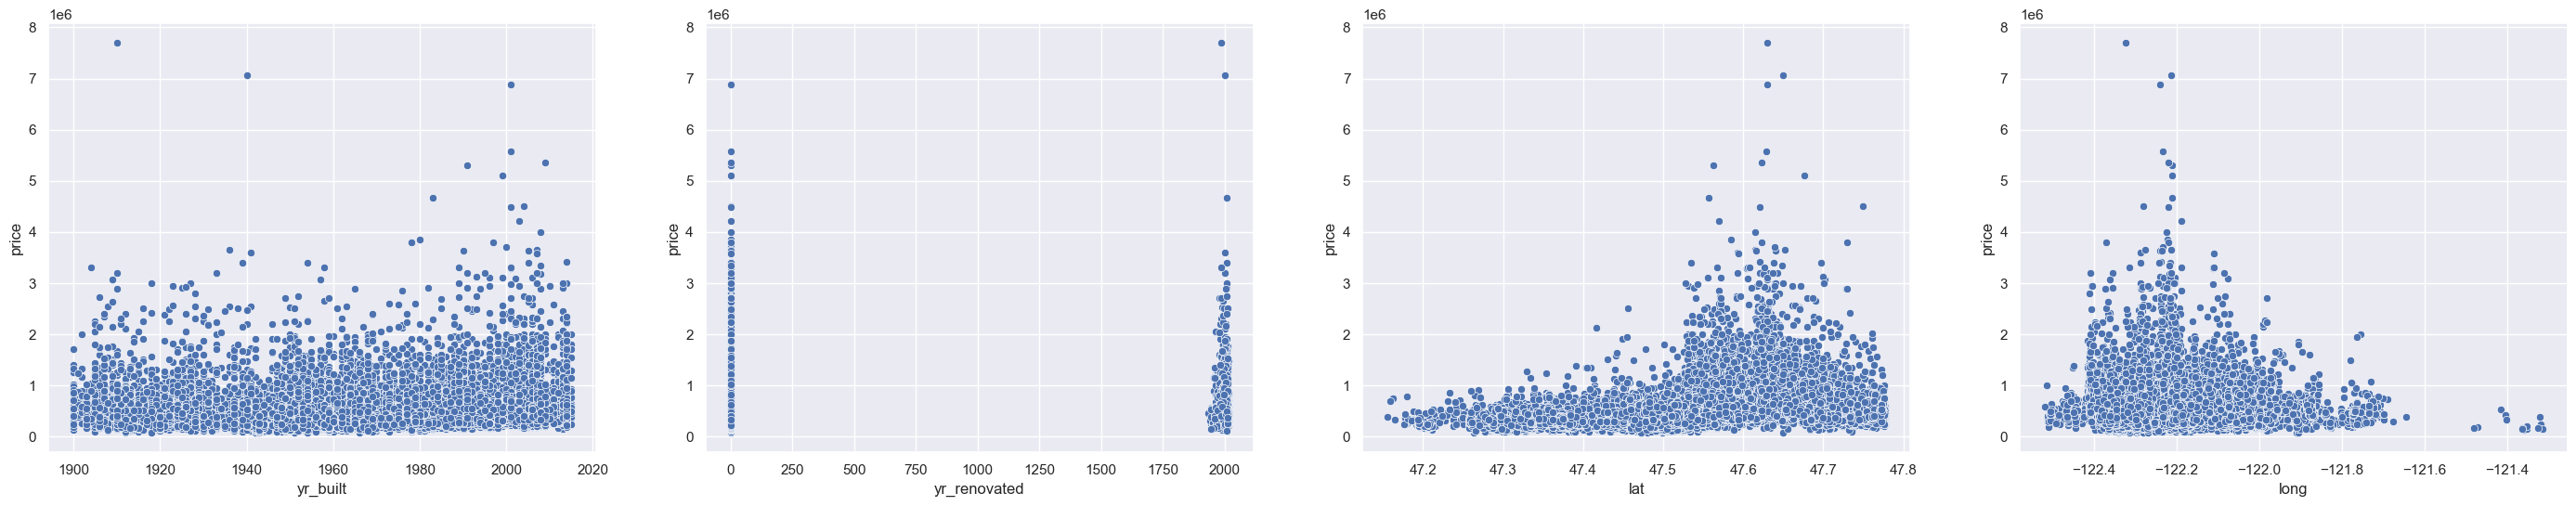

In [72]:
# Scatter plots of yr_built, yr_renovated, lat and long against price
four_scatterplots(data=data, col_range=[9, 13])

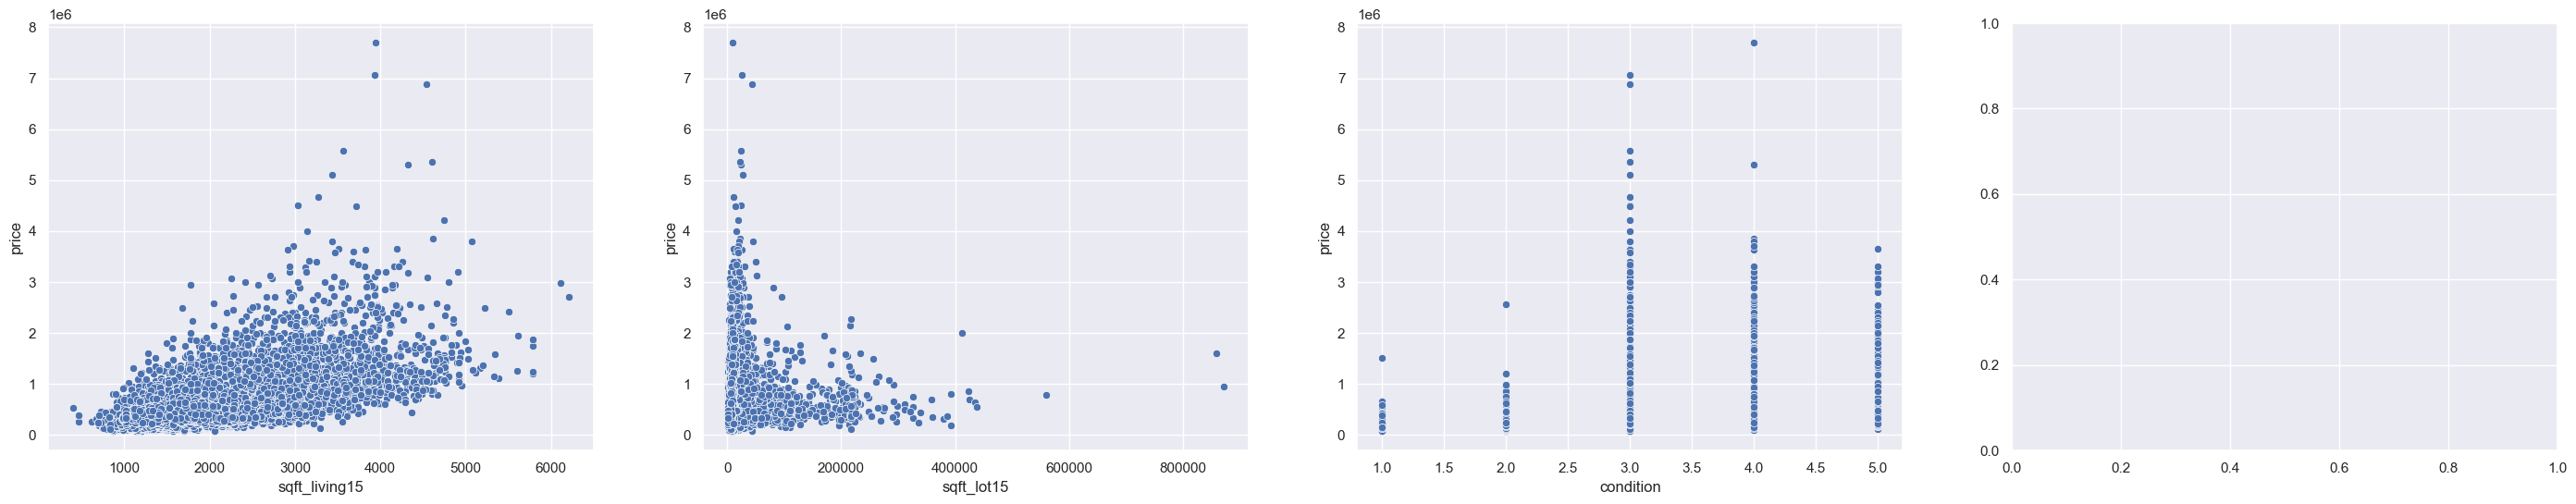

In [73]:
# Scatter plots of sqft_living15, sqft_lot15 and condition against price
four_scatterplots(data=data, col_range=[13, 17])

## Preprocessing & Feature Engineering
There are no missing values in the dataset and all features are already numeric. Some will still need a minor changes.

In [15]:
# Categoricals to be encoded
    # Already encoded: bedrooms, bathrooms, floors, grade, condition
    # These have already been encoded but may need to be adjusted to 0-based encoding if it provides more consistency across the categorical variables or simply performs better with sklearn's algorithms
    # Many of them will need to be transformed so that floats are rounded up for simplicity. I.e., 1.5 bathrooms represents 1 bathroom and an en suite bathroom but this can be considered as 2 bathrooms
    # In the case of floors, 1.5 floors may be one floor and a loft but this can be rounded down to 1 floor, perhaps.
    
# Numeric: I Assume the rest will be numeric and simply needs to be scaled. I am using linear regression and this algorithm will utilise gradient decent to optimise parameter estimates. 
# Continous features that have varying magnitudes need to be scaled to avoid causing issues (such as much slower convergence rates or leading to suboptimal solutions. I don't think suboptimal solutions is as much of an issue here as LR's loss func is convex. 
# Do I need to scale the target variable?

In [16]:
# Checking the distribution of bedrooms
price_df['bedrooms'].value_counts()

3     7865
4     5477
2     2237
5     1292
6      212
1      153
7       29
8        9
0        8
9        5
10       2
33       1
Name: bedrooms, dtype: int64

In [17]:
# Any instances that have less than 1 bedroom or more than 6 bedrooms will be removed
# upper limit set by ~3 standard deviations above the mean

rooms_3_std = 3 * np.std(price_df['bedrooms'])
rooms_3_std_above = price_df['bedrooms'].mean() + rooms_3_std


print(f"Houses that have more than {round(rooms_3_std_above)} rooms are 3 standard deviations above the mean and will be removed.")
price_df = price_df[price_df['bedrooms'] <= 6]

Houses that have more than 6 rooms are 3 standard deviations above the mean and will be removed.


In [18]:
# Checking the distribution of bedrooms
price_df['bathrooms'].value_counts()

2.50    4330
1.00    3088
1.75    2424
2.25    1618
2.00    1525
1.50    1172
2.75     958
3.00     589
3.50     571
3.25     475
3.75     119
4.00     105
4.50      80
4.25      58
0.75      54
4.75      17
5.00      16
5.25      11
1.25       8
0.00       7
5.50       6
0.50       4
6.00       3
6.25       1
7.75       1
8.00       1
5.75       1
6.75       1
6.50       1
Name: bathrooms, dtype: int64

In [19]:
# All values for bathrooms will be rounded down as decimal values represent rooms with a toilet but no shower.
# Any instances that have less than 1 bathroom or more than 5 bathrooms will be removed
# Upper limit set by ~3 standard deviations above the mean

price_df['bathrooms'] = price_df['bathrooms'].round().astype(int)
price_df.head()

bath_3_std = 3 * np.std(price_df['bathrooms'])
bath_3_std_above = price_df['bathrooms'].mean() + rooms_3_std

print(f"Houses that have more than {round(bath_3_std_above)} bathrooms are 3 standard deviations above the mean and will be removed.")
price_df = price_df[price_df['bathrooms'] <= 5]

Houses that have more than 5 bathrooms are 3 standard deviations above the mean and will be removed.


In [20]:
# Checking the distribution of floors
price_df['floors'].value_counts()

1.0    8472
2.0    6591
1.5    1519
3.0     517
2.5     124
3.5       6
Name: floors, dtype: int64

In [21]:
# As homes with .5 floors are defined as split-level or bi-level floors they will be rounded up for simplicity
price_df['floors'] = price_df['floors'].round().astype(int)

In [22]:
# Checking the distribution of grade (no changes will be made)
price_df['grade'].value_counts()

7     7183
8     4864
9     2068
6     1619
10     911
11     296
5      188
12      64
4       26
13       6
3        3
1        1
Name: grade, dtype: int64

In [23]:
# Checking the distribution of condition (no changes will be made)
price_df['condition'].value_counts()

3    11205
4     4499
5     1359
2      139
1       27
Name: condition, dtype: int64

In [24]:
print(price_df.shape)
price_df.head()

(17229, 16)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
6325,325000.0,3,2,1780,13095,1,9,1780,0,1983,0,47.3670,-122.152,2750,13095,4
13473,257000.0,2,1,1000,3700,1,6,800,200,1929,0,47.5520,-122.290,1270,5000,3
17614,228500.0,3,1,1080,7486,2,6,990,90,1942,0,47.4838,-122.335,1170,7800,3
16970,288000.0,3,2,2090,7500,1,7,1280,810,1977,0,47.3951,-122.172,1800,7350,4
20868,479000.0,2,2,1741,1439,2,8,1446,295,2007,0,47.7043,-122.209,2090,10454,3


In [25]:
# yr_built converted into 'age' (at the time the dataset was produced? 2015)
# The primary use of knowing the year a home was built is knowing how old it is. This can be captured by calculating the age. I think it is more suitable to represent this as age instead of a measure of time as there is no time component to this analysis/model.
# Therefor I believe it makes more sense to measure these variables as a count in years instead of an instance in time.

price_df['age'] = 2015 - price_df['yr_built']
reorder_col(data=price_df, col_name='age', after='yr_built') #Reorder the columns so age immediately follows yr_built

price_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,age,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
6325,325000.0,3,2,1780,13095,1,9,1780,0,1983,32,0,47.3670,-122.152,2750,13095,4
13473,257000.0,2,1,1000,3700,1,6,800,200,1929,86,0,47.5520,-122.290,1270,5000,3
17614,228500.0,3,1,1080,7486,2,6,990,90,1942,73,0,47.4838,-122.335,1170,7800,3
16970,288000.0,3,2,2090,7500,1,7,1280,810,1977,38,0,47.3951,-122.172,1800,7350,4
20868,479000.0,2,2,1741,1439,2,8,1446,295,2007,8,0,47.7043,-122.209,2090,10454,3


In [26]:
# For more simplicity so that I don't have to deal with defining the difference between a house that had been renovated that year and one that 
# had never been renovated I may just convert this feature into a binary variable akin to 'renovated in the past 10 years' & 'past 5 years'

# Create new binary columns that specify whether the house has been renovated within 10 years and 5 years, respectively.
renovated_within(data=price_df, yrs_within=10)
renovated_within(data=price_df, yrs_within=5)

# Reorder columns such that the new columns above immediately follow the 'yr_renovated' column
reorder_col(data=price_df, col_name='renovated_within_10_yrs', after='yr_renovated')
reorder_col(data=price_df, col_name='renovated_within_5_yrs', after='renovated_within_10_yrs')

price_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,age,yr_renovated,renovated_within_10_yrs,renovated_within_5_yrs,lat,long,sqft_living15,sqft_lot15,condition
6325,325000.0,3,2,1780,13095,1,9,1780,0,1983,32,0,0,0,47.3670,-122.152,2750,13095,4
13473,257000.0,2,1,1000,3700,1,6,800,200,1929,86,0,0,0,47.5520,-122.290,1270,5000,3
17614,228500.0,3,1,1080,7486,2,6,990,90,1942,73,0,0,0,47.4838,-122.335,1170,7800,3
16970,288000.0,3,2,2090,7500,1,7,1280,810,1977,38,0,0,0,47.3951,-122.172,1800,7350,4
20868,479000.0,2,2,1741,1439,2,8,1446,295,2007,8,0,0,0,47.7043,-122.209,2090,10454,3


In [27]:
# Scale continuous variables with z-score standardisation
# sqft_living, sqft_lot, sqft_above, sqft_basement, age, lat, long, sqft_living15, sqft_lot15

scaler = StandardScaler()

cols_to_scale = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'age', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
price_df[cols_to_scale] = scaler.fit_transform(price_df[cols_to_scale])

In [28]:
price_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,age,yr_renovated,renovated_within_10_yrs,renovated_within_5_yrs,lat,long,sqft_living15,sqft_lot15,condition
6325,325000.0,3,2,-0.321138,-0.043015,1,9,0.000106,-0.658171,1983,-0.403664,0,0,0,-1.393889,0.441633,1.133558,0.015410,4
13473,257000.0,2,1,-1.199223,-0.288214,1,6,-1.209997,-0.196865,1929,1.431912,0,0,0,-0.058594,-0.540077,-1.047688,-0.286593,3
17614,228500.0,3,1,-1.109163,-0.189404,2,6,-0.975385,-0.450584,1942,0.990014,0,0,0,-0.550848,-0.860199,-1.195070,-0.182132,3
16970,288000.0,3,2,0.027845,-0.189039,1,7,-0.617293,1.210118,1977,-0.199711,0,0,0,-1.191068,0.299356,-0.266566,-0.198920,4
20868,479000.0,2,2,-0.365042,-0.347224,2,8,-0.412317,0.022255,2007,-1.219475,0,0,0,1.040679,0.036144,0.160840,-0.083119,3


## Baseline Model
- Do I use the Ridge and Lasso with cross_val_score or do I simply use RidgeCV and LassoCV?

In [29]:
# Pre-processed dataset
X_pp = price_df.drop('price', axis=1)
y_pp = price_df[['price']]

# Data with no pre-processing (for interesting comparison)
X = train_set.drop('price', axis=1) 
y = train_set[['price']]
scaled_X = StandardScaler().fit_transform(X)

### Data with no pre-processing

In [30]:
# Lasso Regression
lasso_reg = Lasso(max_iter=1_000)
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)


# K-fold validation with 5 folds and MSE as the error metric
lasso_scores_mse = cross_val_score(estimator=lasso_reg, 
                                   X=scaled_X,
                                   y=y,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val)


# K-fold validation with 5 folds and R-squared as the error metric
lasso_scores_r2 = cross_val_score(estimator=lasso_reg, 
                                  X=scaled_X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+13, tolerance: 1.850e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+13, tolerance: 1.843e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+13, toleranc

In [31]:
# Average RMSE across all validation folds
np.mean(np.sqrt(-lasso_scores_mse))

211412.44349653422

In [32]:
# Average R-squared across all validation folds
np.mean(lasso_scores_r2)

0.6569455096812147

In [33]:
# Ridge Regression
ridge_reg = Ridge(max_iter=1_000)


# K-fold validation with 5 folds and MSE as the error metric
ridge_scores_mse = cross_val_score(estimator=ridge_reg, 
                                   X=scaled_X,
                                   y=y,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val)


# K-fold validation with 5 folds and R-squared as the error metric
ridge_scores_r2 = cross_val_score(estimator=ridge_reg, 
                                  X=scaled_X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

In [34]:
# Average RMSE across all validation folds
np.mean(np.sqrt(-ridge_scores_mse))

211412.20812275005

In [35]:
# Average R-squared across all validation folds
np.mean(ridge_scores_r2)

0.6569464881741515

### With pre-processing

In [50]:
# Lasso Regression
lasso_reg = Lasso(max_iter=1_000)
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)


# K-fold validation with 5 folds and MSE as the error metric (using preprocessed data)
lasso_scores_mse = cross_val_score(estimator=lasso_reg, 
                                   X=X_pp,
                                   y=y_pp,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val)


# K-fold validation with 5 folds and R-squared as the error metric (using preprocessed data)
lasso_scores_r2 = cross_val_score(estimator=lasso_reg, 
                                  X=X_pp,
                                  y=y_pp,
                                  scoring='r2',
                                  cv=cross_val)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e+13, tolerance: 1.669e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+13, tolerance: 1.612e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+13, toleranc

In [51]:
# Average RMSE across all validation folds
np.mean(np.sqrt(-lasso_scores_mse))

200416.477314552

In [52]:
# Average R-squared across all validation folds
np.mean(lasso_scores_r2)

0.6616653935343806

In [53]:
# Obviously highly correlated: 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated'
remove = ['sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

X_test = X_pp.drop(remove, axis=1)
X_test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,age,renovated_within_10_yrs,renovated_within_5_yrs,lat,long,sqft_living15,sqft_lot15,condition
6325,3,2,-0.321138,-0.043015,1,9,-0.403664,0,0,-1.393889,0.441633,1.133558,0.015410,4
13473,2,1,-1.199223,-0.288214,1,6,1.431912,0,0,-0.058594,-0.540077,-1.047688,-0.286593,3
17614,3,1,-1.109163,-0.189404,2,6,0.990014,0,0,-0.550848,-0.860199,-1.195070,-0.182132,3
16970,3,2,0.027845,-0.189039,1,7,-0.199711,0,0,-1.191068,0.299356,-0.266566,-0.198920,4
20868,2,2,-0.365042,-0.347224,2,8,-1.219475,0,0,1.040679,0.036144,0.160840,-0.083119,3


In [54]:
# K-fold validation with 5 folds and MSE as the error metric (using preprocessed data)
lasso_scores_mse = cross_val_score(estimator=lasso_reg, 
                                   X=X_test,
                                   y=y_pp,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val)


# K-fold validation with 5 folds and R-squared as the error metric (using preprocessed data)
lasso_scores_r2 = cross_val_score(estimator=lasso_reg, 
                                  X=X_test,
                                  y=y_pp,
                                  scoring='r2',
                                  cv=cross_val)

In [48]:
# Average RMSE across all validation folds
np.mean(np.sqrt(-lasso_scores_mse))

200667.45240365536

In [55]:
# Average R-squared across all validation folds
np.mean(lasso_scores_r2)

0.6608039226785201

## Further iterations
- Cross-validate: Use LassoCV to automatically find an optimal α value.
- What is the duality gap? (difference between the solver's precision and the tolerance?)
- Consider switching to ridge regression as apparently lasso can behave erratically when there are features that are strongly correlated.

## Generalisation Error Test

## Further Development